This software is Copyright © 2022 The Regents of the University of California. All Rights Reserved. Permission to copy, modify, and distribute this software and its documentation for educational, research and non-profit purposes, without fee, and without a written agreement is hereby granted, provided that the above copyright notice, this paragraph and the following three paragraphs appear in all copies. Permission to make commercial use of this software may be obtained by contacting:

Office of Innovation and Commercialization

9500 Gilman Drive, Mail Code 0910

University of California

La Jolla, CA 92093-0910

(858) 534-5815

invent@ucsd.edu

This software program and documentation are copyrighted by The Regents of the University of California. The software program and documentation are supplied “as is”, without any accompanying services from The Regents. The Regents does not warrant that the operation of the program will be uninterrupted or error-free. The end-user understands that the program was developed for research purposes and is advised not to rely exclusively on the program for any reason.

IN NO EVENT SHALL THE UNIVERSITY OF CALIFORNIA BE LIABLE TO ANY PARTY FOR DIRECT, INDIRECT, SPECIAL, INCIDENTAL, OR CONSEQUENTIAL DAMAGES, INCLUDING LOST PROFITS, ARISING OUT OF THE USE OF THIS SOFTWARE AND ITS DOCUMENTATION, EVEN IF THE UNIVERSITY OF CALIFORNIA HAS BEEN ADVISED OF THE POSSIBILITY OF SUCH DAMAGE. THE UNIVERSITY OF CALIFORNIA SPECIFICALLY DISCLAIMS ANY WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE. THE SOFTWARE PROVIDED HEREUNDER IS ON AN “AS IS” BASIS, AND THE UNIVERSITY OF CALIFORNIA HAS NO OBLIGATIONS TO PROVIDE MAINTENANCE, SUPPORT, UPDATES, ENHANCEMENTS, OR MODIFICATIONS.

# Are MANRS ASes conformant to Action 1?
MANRS action 1 states that MANRS networks should filter incorrect announcements from their customers.

Paper: https://www.caida.org/catalog/papers/2022_mind_your_manrs/mind_your_manrs.pdf

In [1]:
import pandas as pd
import os
import multiprocessing as mp
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
import requests
from collections import defaultdict
import bz2
import lz4.frame
import urllib
import gzip

In [2]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 200)

# MANRS ASes

Parse ASes in the MANRS Network Operators Program. CSV files can be downloaded from:  
https://www.manrs.org/netops/participants/

In [3]:
manrs = []
manrs_org = {}
manrs_org2as = defaultdict(list)
with open('manrs_isps.csv', 'rt') as f:
    for line in f:
        data = line.strip().split(',')
        if len(data) < 7:
            continue
        asns = data[2].split(';')
        for i in asns:
            try:
                manrs.append(int(i))
                manrs_org[int(i)] = data[0]
                manrs_org2as[data[0]].append(int(i))
            except:
                pass

Parse ASes in the MANRS CDN and Cloud Provider Program. CSV files can be downloaded from:  
https://www.manrs.org/cdn-cloud-providers/participants/

In [4]:
manrscdn = []
with open('manrs_cdns.csv', 'rt') as f:
    for line in f:
        data = line.strip().split(',')
        if len(data) < 7:
            continue
        asns = data[1].split(';')
        for i in asns:
            if not i.isdigit():
                continue
            try:
                manrscdn.append(int(i))
                manrs_org[int(i)] = data[0]
                manrs_org2as[data[0]].append(int(i))
            except:
                pass

In [5]:
manrsas = manrs + manrscdn

## Group by AS size (number of customers)  

### Parse CAIDA AS Relationship Dataset

CAIDA AS Relationship Dataset can be downloaded from:  
https://www.caida.org/catalog/datasets/as-relationships/  
Use files with the extension `.as-rel.txt.bz2`

In [6]:
path = '20220301.as-rel.txt.bz2'   #replace with new file
as_cust = defaultdict(int)
with bz2.open(path, 'rt') as file:
    for line in file:
        if line.startswith('#'):
            continue
        data = line.strip().split('|')
        AS1 = int(data[0])
        AS2 = int(data[1])
        rel = data[2]
        if rel == '1':
            as_cust[AS2] += 1
        elif rel == '-1':
            as_cust[AS1] += 1

In [7]:
cust_deg = pd.DataFrame(as_cust.items(), columns=['asn', 'cust'])
small = cust_deg[cust_deg.cust <= 2]['asn']
medium = cust_deg[(cust_deg.cust > 2) & (cust_deg.cust < 180)]['asn']
large = cust_deg[cust_deg.cust >= 180]['asn']

In [8]:
cust_deg

,asn,cust
0,1,2
1,2,2
2,4,1
3,5,2
4,6,1
...,...,...
11412,399888,1
11413,399895,1
11414,399998,1
11415,400282,1


### separate MANRS and non-MANRS ASes into small, medium, and large catgories

small ASes have # of customers < 2  
medium ASes have # of customers between 2 and 180  
Large ASes have # of customers > 180

In [9]:
medium_manrs = set(manrsas).intersection(set(medium))
large_manrs = set(manrsas).intersection(set(large))
small_manrs = set(manrsas) - medium_manrs - large_manrs

In [10]:
print(len(small_manrs), len(medium_manrs), len(large_manrs))

520 319 24


In [11]:
small_non_manrs = set(small) - small_manrs
medium_non_manrs = set(medium) - medium_manrs
large_non_manrs = set(large) - large_manrs

# AS Customer List

Using the CAIDA AS Relationship Dataset, construct a list of customers for all ASes

CAIDA AS Relationship Dataset can be downloaded from:  
https://www.caida.org/catalog/datasets/as-relationships/  
Use files with the extension `.as-rel.txt.bz2`

In [12]:
path = '20220501.as-rel.txt.bz2'   #replace with new file
as_rel = defaultdict(lambda: defaultdict(set))
with bz2.open(path, 'rt') as file:
    for line in file:
        if line.startswith('#'):
            continue
        data = line.strip().split('|')
        AS1 = int(data[0])
        AS2 = int(data[1])
        rel = data[2]
        if rel == '0':
            as_rel[AS1]['peer'].add(AS2)
            as_rel[AS2]['peer'].add(AS1)
        elif rel == '1':
            as_rel[AS1]['provider'].add(AS2)
            as_rel[AS2]['customer'].add(AS1)
        elif rel == '-1':
            as_rel[AS1]['customer'].add(AS2)
            as_rel[AS2]['provider'].add(AS1)

# RPKI and IRR statuses of prefixes propagated by MANRS and non-MANRS networks

## Process data from the Internet Health Report
IHR data can be downloaded from:  
https://ihr-archive.iijlab.net/ihr/rov/  

IHR also provides a dashboard:  
https://ihr.iijlab.net/ihr/en-us/rov

In [13]:
ihrurl = 'https://ihr-archive.iijlab.net/ihr/rov/2022/05/01/ihr_rov_2022-05-01.csv.lz4' #replace with new file

In [14]:
def process_ihr(url):
    try:
        handle = urllib.request.urlopen(url)
    except:
        print('URL not found', url)
        raise Exception
        return
    with lz4.frame.open(handle) as f:
        df = pd.read_csv(f)
        transitdf = df[df.asn_id != df.originasn_id]
        return transitdf

In [15]:
transitdf = process_ihr(ihrurl)
transitdf = transitdf[transitdf.af == 4]

## Explanation of column names
`prefix`: IP prefix observed in BGP, announced by the AS denoted in `originasn_id`  
`hege`: AS hegemony value, not used in conformance analysis. Ignore column.  
`visibility`: visibility of the prefix in RouteViews and RIPE RIS collectors, not used in conformance analysis. Ignore column.  
`moas`: Whether the `prefix` is announced by multiple origin ASes. `t` for True and `f` for False. Ignore Column.  
`asn_id`: the AS propagating the `prefix`. It is an upstream AS of `originasn_id`  
`originasn_id`: the AS announcing the `prefix` 

In [16]:
transitdf

,id,timebin,prefix,hege,af,visibility,rpki_status,irr_status,delegated_prefix_status,delegated_asn_status,descr,moas,asn_id,country_id,originasn_id
691981,1415697056,2022-05-01 00:00:00+00,165.156.17.0/24,0.027211,4,11.475410,NotFound,Valid,assigned,assigned,Neustar,t,12008,US,397224
691983,1415697054,2022-05-01 00:00:00+00,156.154.101.0/24,0.027211,4,11.475410,NotFound,Valid,assigned,assigned,Neustar,t,12008,US,397224
691985,1415697052,2022-05-01 00:00:00+00,64.6.65.0/24,0.040816,4,12.568306,NotFound,Valid,assigned,assigned,Neustar,t,12008,US,397224
691987,1415697050,2022-05-01 00:00:00+00,156.154.64.0/24,0.040816,4,12.568306,NotFound,Valid,assigned,assigned,Neustar,t,12008,US,397224
691989,1415697048,2022-05-01 00:00:00+00,204.74.112.0/24,0.040816,4,12.568306,NotFound,Valid,assigned,assigned,Neustar,t,12008,US,397224
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5294710,1411094454,2022-05-01 00:00:00+00,1.73.208.0/20,0.047619,4,100.000000,NotFound,Valid,assigned,assigned,"NTT DoCoMo, Inc.",f,3356,JP,9605
5294712,1411094452,2022-05-01 00:00:00+00,1.66.92.0/24,0.258503,4,99.453552,NotFound,Valid,assigned,assigned,"NTT DoCoMo, Inc. expire=24",f,2497,JP,9605
5294713,1411094451,2022-05-01 00:00:00+00,1.66.92.0/24,0.367347,4,99.453552,NotFound,Valid,assigned,assigned,"NTT DoCoMo, Inc. expire=24",f,2914,JP,9605
5294714,1411094450,2022-05-01 00:00:00+00,1.66.92.0/24,0.006803,4,99.453552,NotFound,Valid,assigned,assigned,"NTT DoCoMo, Inc. expire=24",f,3356,JP,9605


## Compute AS relationship between the origin AS and the propagating AS of the prefix

AS relationship between `asn_id` and `originasn_id`  
`relationship` value 'customer' means:  `originasn_id` is a customer of `asn_id`

In [17]:
def lookup_relationship(x):
    origin = x['originasn_id']
    transit = x['asn_id']
    if transit in as_rel:
        if origin in as_rel[transit]['peer']:
            return 'peer'
        elif origin in as_rel[transit]['customer']:
            return 'customer'
        elif origin in as_rel[transit]['provider']:
            return 'provider'
    return 'norel'

In [18]:
transitdf['relationship'] = transitdf.apply(lookup_relationship, axis=1)

In [19]:
transitdf

,id,timebin,prefix,hege,af,visibility,rpki_status,irr_status,delegated_prefix_status,delegated_asn_status,descr,moas,asn_id,country_id,originasn_id,relationship
691981,1415697056,2022-05-01 00:00:00+00,165.156.17.0/24,0.027211,4,11.475410,NotFound,Valid,assigned,assigned,Neustar,t,12008,US,397224,customer
691983,1415697054,2022-05-01 00:00:00+00,156.154.101.0/24,0.027211,4,11.475410,NotFound,Valid,assigned,assigned,Neustar,t,12008,US,397224,customer
691985,1415697052,2022-05-01 00:00:00+00,64.6.65.0/24,0.040816,4,12.568306,NotFound,Valid,assigned,assigned,Neustar,t,12008,US,397224,customer
691987,1415697050,2022-05-01 00:00:00+00,156.154.64.0/24,0.040816,4,12.568306,NotFound,Valid,assigned,assigned,Neustar,t,12008,US,397224,customer
691989,1415697048,2022-05-01 00:00:00+00,204.74.112.0/24,0.040816,4,12.568306,NotFound,Valid,assigned,assigned,Neustar,t,12008,US,397224,customer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5294710,1411094454,2022-05-01 00:00:00+00,1.73.208.0/20,0.047619,4,100.000000,NotFound,Valid,assigned,assigned,"NTT DoCoMo, Inc.",f,3356,JP,9605,customer
5294712,1411094452,2022-05-01 00:00:00+00,1.66.92.0/24,0.258503,4,99.453552,NotFound,Valid,assigned,assigned,"NTT DoCoMo, Inc. expire=24",f,2497,JP,9605,customer
5294713,1411094451,2022-05-01 00:00:00+00,1.66.92.0/24,0.367347,4,99.453552,NotFound,Valid,assigned,assigned,"NTT DoCoMo, Inc. expire=24",f,2914,JP,9605,customer
5294714,1411094450,2022-05-01 00:00:00+00,1.66.92.0/24,0.006803,4,99.453552,NotFound,Valid,assigned,assigned,"NTT DoCoMo, Inc. expire=24",f,3356,JP,9605,customer


## remove bogon ASN

In [20]:
len(transitdf) - len(transitdf[((transitdf.asn_id != 23456) & ((transitdf.asn_id < 64496) | (transitdf.asn_id > 131071)) & ((transitdf.asn_id < 4200000000) | (transitdf.asn_id > 4294967295))) & ((transitdf.originasn_id != 23456) & ((transitdf.originasn_id < 64496) | (transitdf.originasn_id > 131071)) & ((transitdf.originasn_id < 4200000000) | (transitdf.originasn_id > 4294967295)))])

763

In [21]:
transitdf = transitdf[((transitdf.asn_id != 23456) & ((transitdf.asn_id < 64496) | (transitdf.asn_id > 131071)) & ((transitdf.asn_id < 4200000000) | (transitdf.asn_id > 4294967295))) & ((transitdf.originasn_id != 23456) & ((transitdf.originasn_id < 64496) | (transitdf.originasn_id > 131071)) & ((transitdf.originasn_id < 4200000000) | (transitdf.originasn_id > 4294967295)))]

In [22]:
transitdf

,id,timebin,prefix,hege,af,visibility,rpki_status,irr_status,delegated_prefix_status,delegated_asn_status,descr,moas,asn_id,country_id,originasn_id,relationship
691981,1415697056,2022-05-01 00:00:00+00,165.156.17.0/24,0.027211,4,11.475410,NotFound,Valid,assigned,assigned,Neustar,t,12008,US,397224,customer
691983,1415697054,2022-05-01 00:00:00+00,156.154.101.0/24,0.027211,4,11.475410,NotFound,Valid,assigned,assigned,Neustar,t,12008,US,397224,customer
691985,1415697052,2022-05-01 00:00:00+00,64.6.65.0/24,0.040816,4,12.568306,NotFound,Valid,assigned,assigned,Neustar,t,12008,US,397224,customer
691987,1415697050,2022-05-01 00:00:00+00,156.154.64.0/24,0.040816,4,12.568306,NotFound,Valid,assigned,assigned,Neustar,t,12008,US,397224,customer
691989,1415697048,2022-05-01 00:00:00+00,204.74.112.0/24,0.040816,4,12.568306,NotFound,Valid,assigned,assigned,Neustar,t,12008,US,397224,customer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5294710,1411094454,2022-05-01 00:00:00+00,1.73.208.0/20,0.047619,4,100.000000,NotFound,Valid,assigned,assigned,"NTT DoCoMo, Inc.",f,3356,JP,9605,customer
5294712,1411094452,2022-05-01 00:00:00+00,1.66.92.0/24,0.258503,4,99.453552,NotFound,Valid,assigned,assigned,"NTT DoCoMo, Inc. expire=24",f,2497,JP,9605,customer
5294713,1411094451,2022-05-01 00:00:00+00,1.66.92.0/24,0.367347,4,99.453552,NotFound,Valid,assigned,assigned,"NTT DoCoMo, Inc. expire=24",f,2914,JP,9605,customer
5294714,1411094450,2022-05-01 00:00:00+00,1.66.92.0/24,0.006803,4,99.453552,NotFound,Valid,assigned,assigned,"NTT DoCoMo, Inc. expire=24",f,3356,JP,9605,customer


## remove MANRS AS from originasn_id

MANRS ASes should not announce prefixes that are neither RPKI valid nor IRR valid. We study their prefix announcing behavior in Action 4 conformance analysis. Here we remove their BGP announcements from the action 1 conformance study

In [23]:
len(transitdf[transitdf.originasn_id.isin(manrsas)])

165486

In [24]:
transitdf = transitdf[~transitdf.originasn_id.isin(manrsas)]

In [25]:
transitdf

,id,timebin,prefix,hege,af,visibility,rpki_status,irr_status,delegated_prefix_status,delegated_asn_status,descr,moas,asn_id,country_id,originasn_id,relationship
691981,1415697056,2022-05-01 00:00:00+00,165.156.17.0/24,0.027211,4,11.475410,NotFound,Valid,assigned,assigned,Neustar,t,12008,US,397224,customer
691983,1415697054,2022-05-01 00:00:00+00,156.154.101.0/24,0.027211,4,11.475410,NotFound,Valid,assigned,assigned,Neustar,t,12008,US,397224,customer
691985,1415697052,2022-05-01 00:00:00+00,64.6.65.0/24,0.040816,4,12.568306,NotFound,Valid,assigned,assigned,Neustar,t,12008,US,397224,customer
691987,1415697050,2022-05-01 00:00:00+00,156.154.64.0/24,0.040816,4,12.568306,NotFound,Valid,assigned,assigned,Neustar,t,12008,US,397224,customer
691989,1415697048,2022-05-01 00:00:00+00,204.74.112.0/24,0.040816,4,12.568306,NotFound,Valid,assigned,assigned,Neustar,t,12008,US,397224,customer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5294710,1411094454,2022-05-01 00:00:00+00,1.73.208.0/20,0.047619,4,100.000000,NotFound,Valid,assigned,assigned,"NTT DoCoMo, Inc.",f,3356,JP,9605,customer
5294712,1411094452,2022-05-01 00:00:00+00,1.66.92.0/24,0.258503,4,99.453552,NotFound,Valid,assigned,assigned,"NTT DoCoMo, Inc. expire=24",f,2497,JP,9605,customer
5294713,1411094451,2022-05-01 00:00:00+00,1.66.92.0/24,0.367347,4,99.453552,NotFound,Valid,assigned,assigned,"NTT DoCoMo, Inc. expire=24",f,2914,JP,9605,customer
5294714,1411094450,2022-05-01 00:00:00+00,1.66.92.0/24,0.006803,4,99.453552,NotFound,Valid,assigned,assigned,"NTT DoCoMo, Inc. expire=24",f,3356,JP,9605,customer


In [26]:
manrs_transit = transitdf[transitdf.asn_id.isin(manrsas)]
non_manrs_transit = transitdf[~transitdf.asn_id.isin(manrsas)]

In [27]:
manrs_transit['nettype'] = manrs_transit['asn_id'].apply(lambda x: 'CDN' if x in manrscdn else 'ISP')

/home/c4du/miniconda3/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [28]:
small_manrs_transit = manrs_transit[manrs_transit.asn_id.isin(small)]
medium_manrs_transit = manrs_transit[manrs_transit.asn_id.isin(medium)]
large_manrs_transit = manrs_transit[manrs_transit.asn_id.isin(large)]

In [29]:
small_non_manrs_transit = non_manrs_transit[non_manrs_transit.asn_id.isin(small)]
medium_non_manrs_transit = non_manrs_transit[non_manrs_transit.asn_id.isin(medium)]
large_non_manrs_transit = non_manrs_transit[non_manrs_transit.asn_id.isin(large)]

## RPKI: Check if propagated prefixes are RPKI invalid

In [30]:
manrs_transit_rpki = manrs_transit.groupby(['asn_id', 'rpki_status']).size().unstack(fill_value=0).reset_index()
manrs_transit_rpki['rpki_percent'] = (1-manrs_transit_rpki['NotFound']/manrs_transit_rpki[['Invalid', 'Invalid,more-specific', 'Valid', 'NotFound']].sum(axis=1))*100

In [31]:
manrs_transit_rpki['totalPO'] = manrs_transit_rpki[['Invalid', 'Invalid,more-specific', 'Valid', 'NotFound']].sum(axis=1)

In [32]:
non_manrs_transit_rpki = non_manrs_transit.groupby(['asn_id', 'rpki_status']).size().unstack(fill_value=0).reset_index()
non_manrs_transit_rpki['rpki_percent'] = (1-non_manrs_transit_rpki['NotFound']/non_manrs_transit_rpki[['Invalid', 'Invalid,more-specific', 'Valid', 'NotFound']].sum(axis=1))*100

In [33]:
non_manrs_transit_rpki['totalPO'] = non_manrs_transit_rpki[['Invalid', 'Invalid,more-specific', 'Valid', 'NotFound']].sum(axis=1)

### Are MANRS ASes more likely to propagate RPKI valid prefixes than non_MANRS ASes?

The code snippet corresponds to figure 7(a) in the paper

In [34]:
manrs_transit_rpki['invalid_percent'] = (manrs_transit_rpki[['Invalid','Invalid,more-specific']].sum(axis=1)/manrs_transit_rpki[['Invalid','Invalid,more-specific','Valid', 'NotFound']].sum(axis=1))*100
non_manrs_transit_rpki['invalid_percent'] = (non_manrs_transit_rpki[['Invalid','Invalid,more-specific']].sum(axis=1)/non_manrs_transit_rpki[['Invalid','Invalid,more-specific','Valid', 'NotFound']].sum(axis=1))*100
#sibling_non_manrs_transit_rpki['invalid_percent'] = (sibling_non_manrs_transit_rpki['Valid']/sibling_non_manrs_transit_rpki[['Invalid','Invalid,more-specific','Valid']].sum(axis=1))*100



In [35]:
small_manrs_transit_rpki = manrs_transit_rpki[manrs_transit_rpki.asn_id.isin(small)]
medium_manrs_transit_rpki = manrs_transit_rpki[manrs_transit_rpki.asn_id.isin(medium)]
large_manrs_transit_rpki = manrs_transit_rpki[manrs_transit_rpki.asn_id.isin(large)]

small_non_manrs_transit_rpki = non_manrs_transit_rpki[non_manrs_transit_rpki.asn_id.isin(small)]
medium_non_manrs_transit_rpki = non_manrs_transit_rpki[non_manrs_transit_rpki.asn_id.isin(medium)]
large_non_manrs_transit_rpki = non_manrs_transit_rpki[non_manrs_transit_rpki.asn_id.isin(large)]

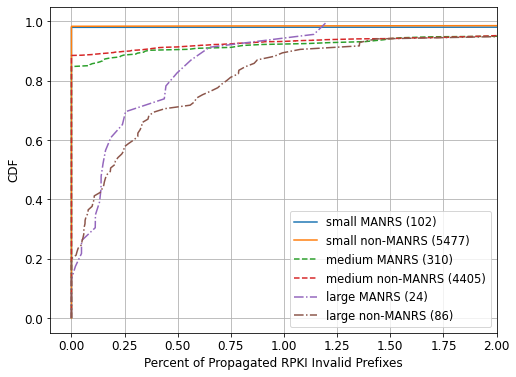

In [36]:
plt.figure(figsize=(8,6))
plt.plot(np.sort(small_manrs_transit_rpki['invalid_percent'].dropna()), np.linspace(0,1,len(small_manrs_transit_rpki['invalid_percent'].dropna())), label='small MANRS ({})'.format(len(small_manrs_transit_rpki.dropna())), linestyle='-')
plt.plot(np.sort(small_non_manrs_transit_rpki['invalid_percent'].dropna()), np.linspace(0,1,len(small_non_manrs_transit_rpki['invalid_percent'].dropna())), label='small non-MANRS ({})'.format(len(small_non_manrs_transit_rpki)), linestyle='-')
plt.plot(np.sort(medium_manrs_transit_rpki['invalid_percent'].dropna()), np.linspace(0,1,len(medium_manrs_transit_rpki['invalid_percent'].dropna())), label='medium MANRS ({})'.format(len(medium_manrs_transit_rpki)), linestyle='--')
plt.plot(np.sort(medium_non_manrs_transit_rpki['invalid_percent'].dropna()), np.linspace(0,1,len(medium_non_manrs_transit_rpki['invalid_percent'].dropna())), label='medium non-MANRS ({})'.format(len(medium_non_manrs_transit_rpki)), linestyle='--')
plt.plot(np.sort(large_manrs_transit_rpki['invalid_percent'].dropna()), np.linspace(0,1,len(large_manrs_transit_rpki['invalid_percent'].dropna())), label='large MANRS ({})'.format(len(large_manrs_transit_rpki)), linestyle='-.')
plt.plot(np.sort(large_non_manrs_transit_rpki['invalid_percent'].dropna()), np.linspace(0,1,len(large_non_manrs_transit_rpki['invalid_percent'].dropna())), label='large non-MANRS ({})'.format(len(large_non_manrs_transit_rpki)), linestyle='-.')
plt.xlabel('Percent of Propagated RPKI Invalid Prefixes', fontsize=12)
plt.ylabel('CDF', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(-0.1, 2)
plt.legend(prop={'size':11.5})
plt.grid()


### Spot check: which MANRS ASes propagated RPKI valid prefixes? 

#### small networks

In [37]:
small_invalid_ASN = small_manrs_transit_rpki[small_manrs_transit_rpki.Invalid > 0]['asn_id']
for i in small_invalid_ASN:
    try:
        print(i, manrs_org[int(i)])
    except:
        print(i)

36914 Kenya Education Network Trust


In [38]:
small_manrs_transit_rpki[small_manrs_transit_rpki.Invalid > 0]

rpki_status,asn_id,Invalid,"Invalid,more-specific",NotFound,Valid,rpki_percent,totalPO,invalid_percent
255,36914,1,0,1,0,50.0,2,50.0


#### medium networks

In [39]:
med_invalid_ASN = medium_manrs_transit_rpki[medium_manrs_transit_rpki.Invalid > 0]['asn_id']
for i in med_invalid_ASN:
    try:
        print(i, manrs_org[int(i)])
    except:
        print(i)

2603 NORDUnet
3303 Swisscom Ltd
4134 China Telecom
4809 China Telecom
7843 Charter Communications
7922 Comcast
8075 Microsoft
8283 Netwerkvereniging ColoClue
8767 M-net Telekommunikations GmbH
10075 Fiber@Home Global Limited
12735 TurkNet Iletisim Hizmetleri A.S.
12779 IT.Gate S.p.A.
12859 BIT BV
16509 Amazon Web Services
18809 Cable Onda
21320 GEANT
22548 NIC.BR - Nucleo de Inf. e Coord. do Ponto BR
24961 myLoc managed IT AG
28007 Gold Data
31549 shatel
33490 Comcast
33650 Comcast
33667 Comcast
34553 Nathan Sales
36925 Orange Morocco
38193 TransWorld Associates Pvt Ltd
39120 Convergenze S.p.A.
41327 Fiber Telecom S.p.A.
45796 United Information Highway
47787 EDGOO NETWORKS LDA
52468 Ufinet
54825 Equinix Metal
57695 Misaka Network Inc.
136308 DeeNet Services Pvt Ltd
139009 Windstream Communication Limited


In [40]:
manrs_transit[manrs_transit.asn_id.isin(med_invalid_ASN) & (manrs_transit.rpki_status == 'Invalid')]

,id,timebin,prefix,hege,af,visibility,rpki_status,irr_status,delegated_prefix_status,delegated_asn_status,descr,moas,asn_id,country_id,originasn_id,relationship,nettype
693752,1415695718,2022-05-01 00:00:00+00,146.109.161.0/24,0.632653,4,54.644809,Invalid,Invalid,assigned,assigned,NaN,f,3303,CH,20743,customer,ISP
695168,1415693750,2022-05-01 00:00:00+00,64.112.228.0/24,0.333333,4,36.065574,Invalid,"Invalid,more-specific",assigned,assigned,Proxy route-object for IP Services,f,33490,US,22171,customer,ISP
695169,1415693749,2022-05-01 00:00:00+00,64.112.228.0/24,0.333333,4,36.065574,Invalid,"Invalid,more-specific",assigned,assigned,Proxy route-object for IP Services,f,7922,US,22171,norel,ISP
699371,1415689703,2022-05-01 00:00:00+00,103.178.187.0/24,0.755102,4,57.377049,Invalid,Invalid,assigned,assigned,"Emran Hossain Oyon\n268/3 Noyatola, Mogbazar",f,10075,BD,149649,norel,ISP
699523,1415689556,2022-05-01 00:00:00+00,103.136.159.0/24,0.544218,4,61.748634,Invalid,Invalid,assigned,assigned,Dhaka Fiber Net Ltd.,f,10075,BD,141731,customer,ISP
699589,1415689423,2022-05-01 00:00:00+00,125.209.90.0/24,0.204082,4,50.273224,Invalid,Invalid,assigned,assigned,ETISALAT-ROUTE,f,38193,PK,135523,norel,ISP
699601,1415689411,2022-05-01 00:00:00+00,111.223.8.0/22,0.455782,4,43.169399,Invalid,Invalid,assigned,assigned,POSDATA,f,4134,CN,109,norel,ISP
699615,1415689397,2022-05-01 00:00:00+00,218.6.171.0/24,0.435374,4,41.530055,Invalid,Valid,assigned,assigned,SICHUANIDC province network,f,4134,CN,139220,norel,ISP
700332,1415689177,2022-05-01 00:00:00+00,203.147.108.0/23,0.027211,4,60.109290,Invalid,Valid,assigned,assigned,APNIC RAND,f,22548,AU,24021,norel,ISP
702060,1415686946,2022-05-01 00:00:00+00,118.184.128.0/21,0.455782,4,43.169399,Invalid,Valid,assigned,assigned,CTJS NJ-IDC,f,4134,CN,137702,customer,ISP


In [41]:
med_invalid_len = medium_manrs_transit_rpki[medium_manrs_transit_rpki['Invalid,more-specific'] > 0]['asn_id']
for i in med_invalid_len:
    try:
        print(i, manrs_org[int(i)])
    except:
        print(i)

3267 RUNNet
3292 TDC
4134 China Telecom
6057 Antel
7922 Comcast
10075 Fiber@Home Global Limited
16010 Magticom
20562 Broadband Hosting B.V.
24785 Broadband Hosting B.V.
34428 GLPR
35297 Dataline LLC
38193 TransWorld Associates Pvt Ltd
42337 Respina Networks & Beyond
52468 Ufinet
52871 USE Telecom
52873 SOFTDADOS CONECTIVIDADE
57695 Misaka Network Inc.
63961 Bangladesh Research and Education Network
139009 Windstream Communication Limited


In [42]:
manrs_transit[manrs_transit.asn_id.isin(med_invalid_len) & (manrs_transit.rpki_status == 'Invalid,more-specific')]

,id,timebin,prefix,hege,af,visibility,rpki_status,irr_status,delegated_prefix_status,delegated_asn_status,descr,moas,asn_id,country_id,originasn_id,relationship,nettype
693183,1415695640,2022-05-01 00:00:00+00,168.181.251.0/24,0.632653,4,50.273224,"Invalid,more-specific",Valid,assigned,assigned,CLIENTE_MOB_LAN SOLUTIONS INFORMATICA LTDA.,f,6057,BR,265349,customer,ISP
693610,1415695860,2022-05-01 00:00:00+00,181.79.0.0/16,0.326531,4,34.426230,"Invalid,more-specific",Valid,assigned,assigned,Globenet Customer - Ufinet - IFX Networks Arge...,f,52468,CO,18747,customer,ISP
693619,1415695851,2022-05-01 00:00:00+00,181.79.0.0/17,0.326531,4,34.426230,"Invalid,more-specific","Invalid,more-specific",assigned,assigned,Globenet Customer - Ufinet - IFX Networks Arge...,f,52468,CO,18747,customer,ISP
699594,1415689418,2022-05-01 00:00:00+00,103.137.24.0/23,0.380952,4,36.065574,"Invalid,more-specific","Invalid,more-specific",assigned,assigned,Pool for Internet Subscribers,f,38193,PK,18053,customer,ISP
699604,1415689408,2022-05-01 00:00:00+00,118.107.143.0/24,0.380952,4,36.065574,"Invalid,more-specific",Invalid,assigned,assigned,TW1 via EMIX route,f,38193,PK,18053,customer,ISP
699837,1415689260,2022-05-01 00:00:00+00,112.124.128.0/17,0.387755,4,44.808743,"Invalid,more-specific","Invalid,more-specific",assigned,assigned,"Hangzhou Alibaba Advertising Co.,Ltd.",f,4134,CN,37963,norel,ISP
699841,1415689256,2022-05-01 00:00:00+00,112.124.0.0/16,0.387755,4,44.808743,"Invalid,more-specific","Invalid,more-specific",assigned,assigned,"Hangzhou Alibaba Advertising Co.,Ltd.",f,4134,CN,37963,norel,ISP
702050,1415686956,2022-05-01 00:00:00+00,125.64.106.0/24,0.435374,4,41.530055,"Invalid,more-specific",Valid,assigned,assigned,SICHUANIDC province network,f,4134,CN,38283,customer,ISP
702120,1415686886,2022-05-01 00:00:00+00,109.244.96.0/20,0.421769,4,41.530055,"Invalid,more-specific","Invalid,more-specific",assigned,assigned,"Tencent Cloud Computing (Beijing) Co., Ltd\n30...",f,4134,CN,45090,norel,ISP
702124,1415686882,2022-05-01 00:00:00+00,109.244.224.0/21,0.421769,4,41.530055,"Invalid,more-specific","Invalid,more-specific",assigned,assigned,"Tencent Cloud Computing (Beijing) Co., Ltd\n30...",f,4134,CN,45090,norel,ISP


#### large networks

In [43]:
large_invalid_ASN = large_manrs_transit_rpki[large_manrs_transit_rpki.Invalid > 0]['asn_id']
for i in large_invalid_ASN:
    try:
        print(i, manrs_org[int(i)])
    except:
        print(i)

174 Cogent Communications Inc.
1299 Arelion
2497 IIJ
2516 KDDI
2914 NTT Communications
3356 CenturyLink
3549 CenturyLink
5511 Orange - Open Transit Internet
6461 Zayo
7015 Comcast
8220 Colt Technology Services
9002 RETN
10796 Charter Communications
14840 BR.Digital Provider
16735 Algar Telecom
20115 Charter Communications
20473 Vultr
53062 GGNET TELECOM


In [44]:
manrs_transit[manrs_transit.asn_id.isin(large_invalid_ASN) & (manrs_transit.rpki_status == 'Invalid')]

,id,timebin,prefix,hege,af,visibility,rpki_status,irr_status,delegated_prefix_status,delegated_asn_status,descr,moas,asn_id,country_id,originasn_id,relationship,nettype
693117,1415695706,2022-05-01 00:00:00+00,200.69.124.0/24,0.306122,4,52.459016,Invalid,Valid,assigned,assigned,TIBA network to be announced,f,6461,CO,21578,norel,ISP
693168,1415695655,2022-05-01 00:00:00+00,165.0.156.0/22,0.034014,4,25.683060,Invalid,Invalid,assigned,assigned,RSAWEB,f,6461,ZA,36994,norel,ISP
693172,1415695651,2022-05-01 00:00:00+00,165.0.144.0/22,0.034014,4,25.683060,Invalid,Invalid,assigned,assigned,RSAWEB,f,6461,ZA,36994,norel,ISP
693176,1415695647,2022-05-01 00:00:00+00,165.0.16.0/22,0.034014,4,25.683060,Invalid,Invalid,assigned,assigned,RSAWEB,f,6461,ZA,12091,norel,ISP
693180,1415695643,2022-05-01 00:00:00+00,165.0.132.0/22,0.034014,4,25.683060,Invalid,Invalid,assigned,assigned,RSAWEB,f,6461,ZA,36994,norel,ISP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5285719,1411102944,2022-05-01 00:00:00+00,109.235.232.0/24,0.741497,4,99.453552,Invalid,Invalid,assigned,assigned,Global Subnet,f,174,FR,8399,customer,ISP
5287653,1411101422,2022-05-01 00:00:00+00,92.38.158.0/24,0.020408,4,96.721311,Invalid,Valid,assigned,assigned,GCL-92-38-158,f,9002,LU,199524,customer,ISP
5289157,1411100352,2022-05-01 00:00:00+00,85.254.180.0/23,0.238095,4,99.453552,Invalid,Invalid,assigned,assigned,LATNET,f,3356,LV,34549,customer,ISP
5291370,1411097780,2022-05-01 00:00:00+00,62.76.164.0/24,0.142857,4,97.814208,Invalid,Valid,assigned,assigned,NaN,f,1299,RU,49505,customer,ISP


In [45]:
large_invalid_len = large_manrs_transit_rpki[large_manrs_transit_rpki['Invalid,more-specific'] > 0]['asn_id']
for i in large_invalid_len:
    try:
        print(i, manrs_org[int(i)])
    except:
        print(i)

174 Cogent Communications Inc.
1299 Arelion
2516 KDDI
2914 NTT Communications
3356 CenturyLink
3549 CenturyLink
5511 Orange - Open Transit Internet
5617 Orange Polska
6461 Zayo
7015 Comcast
9002 RETN
13335 Cloudflare
14840 BR.Digital Provider
16735 Algar Telecom
20473 Vultr
53062 GGNET TELECOM


In [46]:
manrs_transit[manrs_transit.asn_id.isin(large_invalid_len) & (manrs_transit.rpki_status == 'Invalid,more-specific')]

,id,timebin,prefix,hege,af,visibility,rpki_status,irr_status,delegated_prefix_status,delegated_asn_status,descr,moas,asn_id,country_id,originasn_id,relationship,nettype
693132,1415695691,2022-05-01 00:00:00+00,201.159.163.0/24,0.115646,4,51.912568,"Invalid,more-specific","Invalid,more-specific",assigned,assigned,AS270793,f,6461,BR,270793,norel,ISP
693137,1415695686,2022-05-01 00:00:00+00,45.179.218.0/23,0.312925,4,51.912568,"Invalid,more-specific","Invalid,more-specific",assigned,assigned,Customer American Tower,f,6461,BR,269193,norel,ISP
693184,1415695639,2022-05-01 00:00:00+00,168.181.251.0/24,0.278912,4,50.273224,"Invalid,more-specific",Valid,assigned,assigned,CLIENTE_MOB_LAN SOLUTIONS INFORMATICA LTDA.,f,6461,BR,265349,norel,ISP
693459,1415695427,2022-05-01 00:00:00+00,216.2.194.0/24,0.306122,4,28.415301,"Invalid,more-specific",Invalid,assigned,assigned,Proxy registration to prevent harm from ARIN-N...,f,6461,US,19720,norel,ISP
693508,1415695378,2022-05-01 00:00:00+00,216.126.148.0/22,0.591837,4,49.180328,"Invalid,more-specific",Valid,assigned,assigned,Proxy fbo Windstream Customer,f,6461,US,7029,customer,ISP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5291435,1411097720,2022-05-01 00:00:00+00,61.246.214.0/24,0.142857,4,53.551913,"Invalid,more-specific",Valid,assigned,assigned,INDIA,f,6461,IN,9498,customer,ISP
5291500,1411097603,2022-05-01 00:00:00+00,59.145.202.0/24,0.142857,4,53.551913,"Invalid,more-specific",Valid,assigned,assigned,INDIA,f,6461,IN,9498,customer,ISP
5291503,1411097600,2022-05-01 00:00:00+00,59.145.238.0/24,0.142857,4,53.551913,"Invalid,more-specific",Valid,assigned,assigned,INDIA,f,6461,IN,9498,customer,ISP
5291527,1411097576,2022-05-01 00:00:00+00,59.144.120.0/24,0.142857,4,53.551913,"Invalid,more-specific",Valid,assigned,assigned,INDIA,f,6461,IN,9498,customer,ISP


## IRR: Check if propagated prefixes are IRR invalid

In [47]:
manrs_transit_irr = manrs_transit.groupby(['asn_id', 'irr_status']).size().unstack(fill_value=0).reset_index()
manrs_transit_irr['irr_percent'] = (1-manrs_transit_irr['NotFound']/manrs_transit_irr[['Invalid', 'Invalid,more-specific', 'Valid', 'NotFound']].sum(axis=1))*100
manrs_transit_irr['totalPO'] = manrs_transit_irr[['Invalid', 'Invalid,more-specific', 'Valid', 'NotFound']].sum(axis=1)

In [48]:
non_manrs_transit_irr = non_manrs_transit.groupby(['asn_id', 'irr_status']).size().unstack(fill_value=0).reset_index()
non_manrs_transit_irr['irr_percent'] = (1-non_manrs_transit_irr['NotFound']/non_manrs_transit_irr[['Invalid', 'Invalid,more-specific', 'Valid', 'NotFound']].sum(axis=1))*100
non_manrs_transit_irr['totalPO'] = non_manrs_transit_irr[['Invalid', 'Invalid,more-specific', 'Valid', 'NotFound']].sum(axis=1)

### Are MANRS ASes more likely to originate IRR valid prefixes than non_MANRS ASes?

The code snippet corresponds to figure 7(b) in the paper

In [49]:
manrs_transit_irr['invalid_percent'] = (manrs_transit_irr[['Invalid']].sum(axis=1)/manrs_transit_irr[['Invalid','Invalid,more-specific','Valid']].sum(axis=1))*100
non_manrs_transit_irr['invalid_percent'] = (non_manrs_transit_irr[['Invalid']].sum(axis=1)/non_manrs_transit_irr[['Invalid','Invalid,more-specific','Valid']].sum(axis=1))*100

In [50]:
small_manrs_transit_irr = manrs_transit_irr[manrs_transit_irr.asn_id.isin(small)]
medium_manrs_transit_irr = manrs_transit_irr[manrs_transit_irr.asn_id.isin(medium)]
large_manrs_transit_irr = manrs_transit_irr[manrs_transit_irr.asn_id.isin(large)]
small_non_manrs_transit_irr = non_manrs_transit_irr[non_manrs_transit_irr.asn_id.isin(small)]
medium_non_manrs_transit_irr = non_manrs_transit_irr[non_manrs_transit_irr.asn_id.isin(medium)]
large_non_manrs_transit_irr = non_manrs_transit_irr[non_manrs_transit_irr.asn_id.isin(large)]

In [51]:
print(len(small_manrs), len(medium_manrs), len(large_manrs))

520 319 24


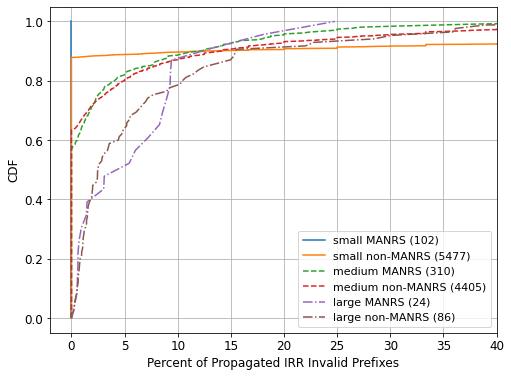

In [52]:
plt.figure(figsize=(8,6))
plt.plot(np.sort(small_manrs_transit_irr['invalid_percent'].dropna()), np.linspace(0,1,len(small_manrs_transit_irr['invalid_percent'].dropna())), label='small MANRS ({})'.format(len(small_manrs_transit_irr.dropna())), linestyle='-')
plt.plot(np.sort(small_non_manrs_transit_irr['invalid_percent'].dropna()), np.linspace(0,1,len(small_non_manrs_transit_irr['invalid_percent'].dropna())), label='small non-MANRS ({})'.format(len(small_non_manrs_transit_irr)), linestyle='-')
plt.plot(np.sort(medium_manrs_transit_irr['invalid_percent'].dropna()), np.linspace(0,1,len(medium_manrs_transit_irr['invalid_percent'].dropna())), label='medium MANRS ({})'.format(len(medium_manrs_transit_irr)), linestyle='--')
plt.plot(np.sort(medium_non_manrs_transit_irr['invalid_percent'].dropna()), np.linspace(0,1,len(medium_non_manrs_transit_irr['invalid_percent'].dropna())), label='medium non-MANRS ({})'.format(len(medium_non_manrs_transit_irr)), linestyle='--')
plt.plot(np.sort(large_manrs_transit_irr['invalid_percent'].dropna()), np.linspace(0,1,len(large_manrs_transit_irr['invalid_percent'].dropna())), label='large MANRS ({})'.format(len(large_manrs_transit_irr)), linestyle='-.')
plt.plot(np.sort(large_non_manrs_transit_irr['invalid_percent'].dropna()), np.linspace(0,1,len(large_non_manrs_transit_irr['invalid_percent'].dropna())), label='large non-MANRS ({})'.format(len(large_non_manrs_transit_irr)), linestyle='-.')
plt.xlabel('Percent of Propagated IRR Invalid Prefixes', fontsize=12)
plt.ylabel('CDF', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(prop={'size':11})
plt.xlim(-2,40)
plt.grid()

# **MANRS Action 1 Conformance**

In [53]:
def irr_or_rpki(r):
    if (r['irr_status'] == 'Invalid' and r['rpki_status'] == 'NotFound') or r['rpki_status'] == 'Invalid' or r['rpki_status'] == 'Invalid,more-specific':
        return True
    return False

In [54]:
manrs_transit

,id,timebin,prefix,hege,af,visibility,rpki_status,irr_status,delegated_prefix_status,delegated_asn_status,descr,moas,asn_id,country_id,originasn_id,relationship,nettype
691991,1415697046,2022-05-01 00:00:00+00,46.200.62.0/24,0.006803,4,10.382514,NotFound,"Invalid,more-specific",assigned,assigned,AGGREGATE BLOCK FOR UKRTELECOM,f,9002,UA,6849,customer,ISP
691994,1415697043,2022-05-01 00:00:00+00,66.94.13.0/24,0.006803,4,11.475410,Valid,Valid,assigned,assigned,x,f,9002,US,21928,peer,ISP
691996,1415697041,2022-05-01 00:00:00+00,46.201.188.0/23,0.006803,4,10.382514,NotFound,"Invalid,more-specific",assigned,assigned,AGGREGATE BLOCK FOR UKRTELECOM,f,9002,UA,6849,customer,ISP
691999,1415697038,2022-05-01 00:00:00+00,46.201.168.0/23,0.006803,4,10.382514,NotFound,"Invalid,more-specific",assigned,assigned,AGGREGATE BLOCK FOR UKRTELECOM,f,9002,UA,6849,customer,ISP
692001,1415697036,2022-05-01 00:00:00+00,46.200.168.0/23,0.006803,4,10.382514,NotFound,"Invalid,more-specific",assigned,assigned,AGGREGATE BLOCK FOR UKRTELECOM,f,9002,UA,6849,customer,ISP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5294709,1411094455,2022-05-01 00:00:00+00,1.73.208.0/20,0.646259,4,100.000000,NotFound,Valid,assigned,assigned,"NTT DoCoMo, Inc.",f,2497,JP,9605,customer,ISP
5294710,1411094454,2022-05-01 00:00:00+00,1.73.208.0/20,0.047619,4,100.000000,NotFound,Valid,assigned,assigned,"NTT DoCoMo, Inc.",f,3356,JP,9605,customer,ISP
5294712,1411094452,2022-05-01 00:00:00+00,1.66.92.0/24,0.258503,4,99.453552,NotFound,Valid,assigned,assigned,"NTT DoCoMo, Inc. expire=24",f,2497,JP,9605,customer,ISP
5294713,1411094451,2022-05-01 00:00:00+00,1.66.92.0/24,0.367347,4,99.453552,NotFound,Valid,assigned,assigned,"NTT DoCoMo, Inc. expire=24",f,2914,JP,9605,customer,ISP


In [55]:
manrs_transit['either_status'] = manrs_transit.apply(irr_or_rpki, axis=1)

/home/c4du/miniconda3/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [56]:
non_manrs_transit['either_status'] = non_manrs_transit.apply(irr_or_rpki, axis=1)

In [57]:
manrs_transit_either = manrs_transit.groupby(['asn_id', 'either_status']).size().unstack(fill_value=0).reset_index()

In [58]:
non_manrs_transit_either = non_manrs_transit.groupby(['asn_id', 'either_status']).size().unstack(fill_value=0).reset_index()

## Terminology: Explanation of column names
`either_status`: Index of each row  
`originasn_id`: A MANRS AS  
`True`: Number of prefixes announnced by the `originasn_id` that is RPKI Invalid, or (RPKI Not Found and IRR Invalid). These prefixes are supposed to be filtered out by MANRS ASes. MANRS ASes that propagate such prefixes maybe non-conformant.    
`False`: Number of prefixes announced by the `originasn_id` that is opposite of `True`

In [59]:
manrs_transit_either[manrs_transit_either[False] > 0]

either_status,asn_id,False,True
0,101,179,0
1,137,45,0
2,174,422993,34778
3,237,181,8
4,271,103,1
...,...,...,...
447,328073,3,0
448,328271,2,0
449,328594,42,0
450,328748,8,0


In [60]:
manrs_transit_either['invalid_percent'] = manrs_transit_either[True]/(manrs_transit_either[False] + manrs_transit_either[True])*100

In [61]:
non_manrs_transit_either['invalid_percent'] = non_manrs_transit_either[True]/(non_manrs_transit_either[False] + non_manrs_transit_either[True])*100

In [62]:
small_manrs_transit_either = manrs_transit_either[manrs_transit_either.asn_id.isin(small)]
medium_manrs_transit_either = manrs_transit_either[manrs_transit_either.asn_id.isin(medium)]
large_manrs_transit_either = manrs_transit_either[manrs_transit_either.asn_id.isin(large)]
small_non_manrs_transit_either = non_manrs_transit_either[non_manrs_transit_either.asn_id.isin(small)]
medium_non_manrs_transit_either = non_manrs_transit_either[non_manrs_transit_either.asn_id.isin(medium)]
large_non_manrs_transit_either = non_manrs_transit_either[non_manrs_transit_either.asn_id.isin(large)]

## Compare Conformance between MANRS and non-MANRS networks

The code snippet corresponds to figure 8 in the paper

In [63]:
manrs_transit_either_rel = manrs_transit.groupby(['asn_id', 'relationship', 'either_status']).size().unstack(fill_value=0).reset_index()
non_manrs_transit_either_rel = non_manrs_transit.groupby(['asn_id', 'relationship', 'either_status']).size().unstack(fill_value=0).reset_index()

In [64]:
manrs_transit_either_rel['invalid_percent'] = manrs_transit_either_rel[True]/(manrs_transit_either_rel[False] + manrs_transit_either_rel[True])*100
non_manrs_transit_either_rel['invalid_percent'] = non_manrs_transit_either_rel[True]/(non_manrs_transit_either_rel[False] + non_manrs_transit_either_rel[True])*100

In [65]:
manrs_transit_either_rel = manrs_transit_either_rel[manrs_transit_either_rel.relationship != 'norel']
manrs_transit_either_rel = manrs_transit_either_rel[manrs_transit_either_rel.relationship != 'provider']

In [66]:
non_manrs_transit_either_rel = non_manrs_transit_either_rel[non_manrs_transit_either_rel.relationship != 'norel']
non_manrs_transit_either_rel = non_manrs_transit_either_rel[non_manrs_transit_either_rel.relationship != 'provider']

In [67]:
manrs_transit_either_rel['totalPO'] = manrs_transit_either_rel[False] + manrs_transit_either_rel[True]

In [68]:
manrs_transit_either_rel_isp = manrs_transit_either_rel[manrs_transit_either_rel.relationship != 'peer']

In [69]:
non_manrs_transit_either_rel_isp = non_manrs_transit_either_rel[non_manrs_transit_either_rel.relationship != 'peer']

In [70]:
small_manrs_transit_either_rel_isp = manrs_transit_either_rel_isp[manrs_transit_either_rel_isp.asn_id.isin(small)]
medium_manrs_transit_either_rel_isp = manrs_transit_either_rel_isp[manrs_transit_either_rel_isp.asn_id.isin(medium)]
large_manrs_transit_either_rel_isp = manrs_transit_either_rel_isp[manrs_transit_either_rel_isp.asn_id.isin(large)]
small_non_manrs_transit_either_rel_isp = non_manrs_transit_either_rel_isp[non_manrs_transit_either_rel_isp.asn_id.isin(small)]
medium_non_manrs_transit_either_rel_isp = non_manrs_transit_either_rel_isp[non_manrs_transit_either_rel_isp.asn_id.isin(medium)]
large_non_manrs_transit_either_rel_isp = non_manrs_transit_either_rel_isp[non_manrs_transit_either_rel_isp.asn_id.isin(large)]

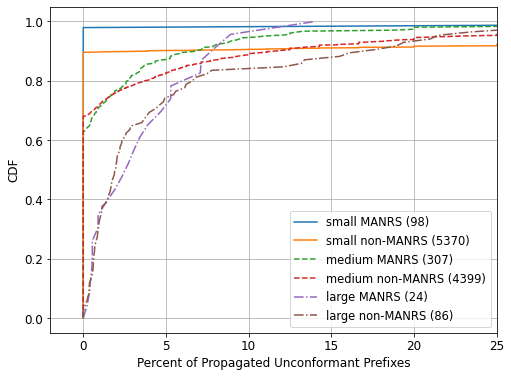

In [71]:
plt.figure(figsize=(8,6))
plt.plot(np.sort(small_manrs_transit_either_rel_isp['invalid_percent']), np.linspace(0,1,len(small_manrs_transit_either_rel_isp)), label='small MANRS ({})'.format(len(small_manrs_transit_either_rel_isp)), linestyle='-')
plt.plot(np.sort(small_non_manrs_transit_either_rel_isp['invalid_percent']), np.linspace(0,1,len(small_non_manrs_transit_either_rel_isp)), label='small non-MANRS ({})'.format(len(small_non_manrs_transit_either_rel_isp)), linestyle='-')
plt.plot(np.sort(medium_manrs_transit_either_rel_isp['invalid_percent']), np.linspace(0,1,len(medium_manrs_transit_either_rel_isp)), label='medium MANRS ({})'.format(len(medium_manrs_transit_either_rel_isp)), linestyle='--')
plt.plot(np.sort(medium_non_manrs_transit_either_rel_isp['invalid_percent']), np.linspace(0,1,len(medium_non_manrs_transit_either_rel_isp)), label='medium non-MANRS ({})'.format(len(medium_non_manrs_transit_either_rel_isp)), linestyle='--')
plt.plot(np.sort(large_manrs_transit_either_rel_isp['invalid_percent']), np.linspace(0,1,len(large_manrs_transit_either_rel_isp)), label='large MANRS ({})'.format(len(large_manrs_transit_either_rel_isp)), linestyle='-.')
plt.plot(np.sort(large_non_manrs_transit_either_rel_isp['invalid_percent']), np.linspace(0,1,len(large_non_manrs_transit_either_rel_isp)), label='large non-MANRS ({})'.format(len(large_non_manrs_transit_either_rel_isp)), linestyle='-.')
#plt.axvline(x=10, linestyle=':', color='blue', linewidth=1.25)
#plt.text(7, -0.14, '10', color='blue', size=13)
plt.xlabel('Percent of Propagated Unconformant Prefixes', fontsize=12)
plt.ylabel('CDF', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(-2, 25)
plt.legend(prop={'size':11.5})
plt.grid()

## **Non-conformant MANRS ASes**

In [72]:
manrs_transit_either_rel_isp['company'] = manrs_transit_either_rel_isp['asn_id'].apply(lambda x: manrs_org[x])

/home/c4du/miniconda3/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [73]:
manrs_transit_either_rel_isp[(manrs_transit_either_rel_isp.asn_id.isin(small)) & (manrs_transit_either_rel_isp.invalid_percent>0)]

either_status,asn_id,relationship,False,True,invalid_percent,totalPO,company
424,36914,customer,1,1,50.000000,2,Kenya Education Network Trust
698,271915,customer,2,1,33.333333,3,TECNOLOGICA SIMEON COMPANY CHILE SPA


In [74]:
manrs_transit_either_rel_isp[(manrs_transit_either_rel_isp.asn_id.isin(medium)) & (manrs_transit_either_rel_isp.invalid_percent>0)]

either_status,asn_id,relationship,False,True,invalid_percent,totalPO,company
7,237,customer,132,5,3.649635,137,Merit Network Inc.
9,271,customer,101,1,0.980392,102,BCNET
15,376,customer,52,1,1.886792,53,Réseau d'informations scientifiques du Québec ...
36,1653,customer,72,2,2.702703,74,SUNET
41,1916,customer,178,3,1.657459,181,Rede Nacional de Ensino e Pesquisa
44,2110,customer,91,1,1.086957,92,BT Ireland
55,2518,customer,246,1,0.404858,247,BIGLOBE Inc.
62,2614,customer,66,1,1.492537,67,Agency ARNIEC - RoEduNet
68,3267,customer,199,1,0.500000,200,RUNNet
70,3292,customer,467,9,1.890756,476,TDC


In [75]:
manrs_transit_either_rel_isp[(manrs_transit_either_rel_isp.asn_id.isin(large)) & (manrs_transit_either_rel_isp.invalid_percent>0)]

either_status,asn_id,relationship,False,True,invalid_percent,totalPO,company
4,174,customer,140461,7841,5.287184,148302,Cogent Communications Inc.
28,1221,customer,1816,74,3.915344,1890,Telstra Corporation Ltd
32,1299,customer,104044,2920,2.729890,106964,Arelion
50,2497,customer,3580,16,0.444939,3596,IIJ
52,2516,customer,1779,16,0.891365,1795,KDDI
64,2914,customer,49652,1197,2.354029,50849,NTT Communications
76,3356,customer,131945,7384,5.299686,139329,CenturyLink
79,3549,customer,5004,381,7.075209,5385,CenturyLink
110,5511,customer,11122,157,1.391967,11279,Orange - Open Transit Internet
116,5617,customer,509,10,1.926782,519,Orange Polska
